In [1]:
# STEP 1: Setup and Configuration
# ⚠️ USER_ID is set to 6 for this low-quality data processing

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display
import csv

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')
sys.path.append('scripts')

# Import TCX parser
from parse_tcx import parse_tcx_to_df

# ⚠️ CONFIGURATION - User 6 identified as low quality data
USER_ID = 6
TCX_FILE = f'data/{USER_ID}-d.tcx'
OUTPUT_CSV = f'output/processed/user_{USER_ID}_station_data_low_quality.csv'

print(f"🚨 LOW QUALITY DATA PROCESSING for User {USER_ID}")
print(f"📁 TCX file: {TCX_FILE}")
print(f"💾 Output CSV: {OUTPUT_CSV}")
print("✅ Libraries loaded successfully")


🚨 LOW QUALITY DATA PROCESSING for User 6
📁 TCX file: data/6-d.tcx
💾 Output CSV: output/processed/user_6_station_data_low_quality.csv
✅ Libraries loaded successfully


In [2]:
# STEP 2: Load and Parse TCX Data
# Handle potential parsing errors gracefully

try:
    result = parse_tcx_to_df(TCX_FILE)
    if len(result) == 4:
        df, session_total_sec, session_avg_hr, session_max_hr = result
        calories_burned = None
    else:
        df, session_total_sec, session_avg_hr, session_max_hr, calories_burned = result
    
    session_duration_min = session_total_sec / 60
    
    print(f"✅ Successfully parsed TCX file")
    print(f"📊 Raw Data Summary:")
    print(f"   Duration: {session_duration_min:.2f} minutes")
    print(f"   Data points: {len(df)}")
    print(f"   Average HR: {session_avg_hr:.1f} bpm")
    print(f"   Maximum HR: {session_max_hr} bpm")
    if calories_burned:
        print(f"   Calories: {calories_burned}")
    
    # Display first few rows
    print(f"\n📋 Data Preview:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error parsing TCX file: {e}")
    print("Please check that the TCX file exists and is valid.")
    raise


✅ Successfully parsed TCX file
📊 Raw Data Summary:
   Duration: 43.05 minutes
   Data points: 53
   Average HR: 167.3 bpm
   Maximum HR: 197 bpm
   Calories: 132

📋 Data Preview:


,timestamp,heart_rate,start_time,elapsed_min
0,2025-03-06 12:27:59+00:00,138,2025-03-06 12:27:59+00:00,0.000000
1,2025-03-06 12:28:09+00:00,137,2025-03-06 12:27:59+00:00,0.166667
2,2025-03-06 12:28:19+00:00,131,2025-03-06 12:27:59+00:00,0.333333
3,2025-03-06 12:28:41+00:00,121,2025-03-06 12:27:59+00:00,0.700000
4,2025-03-06 12:29:29+00:00,126,2025-03-06 12:27:59+00:00,1.500000


In [3]:
# STEP 3: Data Quality Assessment
# Analyze data density and identify quality issues

print("=" * 80)
print(f"USER {USER_ID} DATA QUALITY ASSESSMENT")
print("=" * 80)

# Calculate data density
data_points_per_minute = len(df) / session_duration_min
expected_points_per_minute = 12  # Typical Garmin recording rate

# Assess data quality based on density
if data_points_per_minute < 3:
    quality_level = "VERY LOW"
    quality_reason = "Severe sensor disconnection - extremely sparse data"
elif data_points_per_minute < 6:
    quality_level = "LOW"
    quality_reason = "Frequent sensor disconnections - insufficient data density"
elif data_points_per_minute < 10:
    quality_level = "MARGINAL"
    quality_reason = "Intermittent sensor issues - below normal recording rate"
else:
    quality_level = "ACCEPTABLE"
    quality_reason = "Data density acceptable but may have other quality issues"

print(f"\n🚨 DATA QUALITY: {quality_level}")
print(f"\n📊 Quality Metrics:")
print(f"   Data density: {data_points_per_minute:.1f} points/minute")
print(f"   Expected density: ~{expected_points_per_minute} points/minute")
print(f"   Coverage: {(data_points_per_minute/expected_points_per_minute)*100:.1f}% of expected")
print(f"   Assessment: {quality_reason}")

# Additional quality checks
hr_range = df['heart_rate'].max() - df['heart_rate'].min()
hr_std = df['heart_rate'].std()
time_gaps = df['elapsed_min'].diff().describe()

print(f"\n📈 Heart Rate Characteristics:")
print(f"   Range: {hr_range} bpm (min: {df['heart_rate'].min()}, max: {df['heart_rate'].max()})")
print(f"   Standard deviation: {hr_std:.1f} bpm")
print(f"   Mean recording interval: {time_gaps['mean']:.2f} minutes")
print(f"   Max gap between readings: {time_gaps['max']:.2f} minutes")

# Store quality assessment for CSV export
quality_summary = f"{quality_level} QUALITY DATA: Data density {data_points_per_minute:.1f} points/minute ({(data_points_per_minute/expected_points_per_minute)*100:.1f}% of expected). {quality_reason}. Heart rate range {hr_range} bpm with {hr_std:.1f} bpm standard deviation. Maximum recording gap {time_gaps['max']:.2f} minutes indicates sensor connection issues."


USER 6 DATA QUALITY ASSESSMENT

🚨 DATA QUALITY: VERY LOW

📊 Quality Metrics:
   Data density: 1.2 points/minute
   Expected density: ~12 points/minute
   Coverage: 10.3% of expected
   Assessment: Severe sensor disconnection - extremely sparse data

📈 Heart Rate Characteristics:
   Range: 76 bpm (min: 121, max: 197)
   Standard deviation: 16.8 bpm
   Mean recording interval: 0.83 minutes
   Max gap between readings: 6.03 minutes


In [4]:
# STEP 4: Load User Metadata (if available)
# Attempt to load demographic and session information

try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == USER_ID]
    
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"✅ Loaded metadata for user {USER_ID}:")
        print(f"   Age: {age}, Gender: {gender}")
        print(f"   Height: {height_cm}cm, Weight: {weight_kg}kg")
        print(f"   Champion number: {champ_number}")
    else:
        print(f"⚠️ No metadata found for user {USER_ID}")
        age = gender = height_cm = weight_kg = champ_number = None
        
except Exception as e:
    print(f"⚠️ Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None

✅ Loaded metadata for user 6:
   Age: None, Gender:  
   Height: Nonecm, Weight: Nonekg
   Champion number: 5


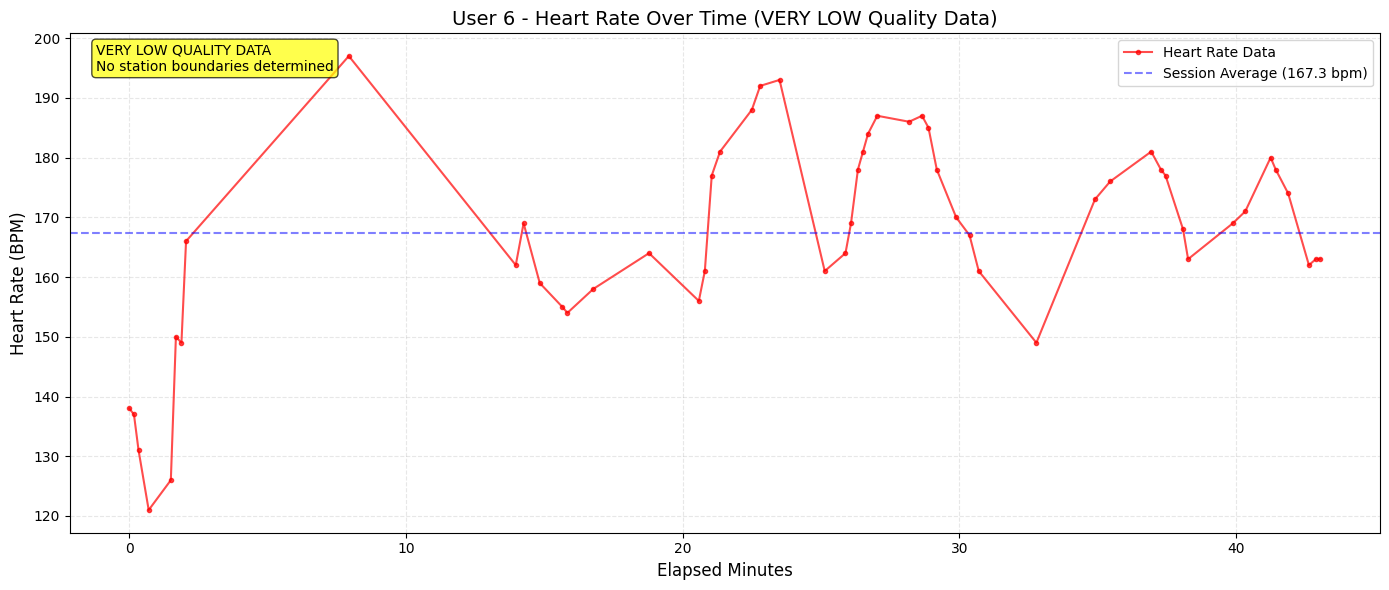

✅ Documentation plot saved to: output/plots/user_6/heart_rate_over_time_low_quality.png
📊 Data points plotted: 53
⚠️ No station-based analysis performed due to data quality issues


In [5]:
# STEP 5: Create Documentation Plot
# Simple heart rate over time plot for research documentation

# Create output directory
plots_dir = f'output/plots/user_{USER_ID}'
os.makedirs(plots_dir, exist_ok=True)

# Create documentation plot
plt.figure(figsize=(14, 6))

# Plot raw heart rate data
plt.plot(df['elapsed_min'], df['heart_rate'], 
         marker='o', markersize=3, linewidth=1.5, 
         color='red', alpha=0.7, label='Heart Rate Data')

# Add quality indicator
plt.axhline(y=df['heart_rate'].mean(), color='blue', linestyle='--', 
           alpha=0.5, label=f'Session Average ({df["heart_rate"].mean():.1f} bpm)')

# Formatting
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title(f'User {USER_ID} - Heart Rate Over Time ({quality_level} Quality Data)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

# Add quality annotation
plt.text(0.02, 0.98, f'{quality_level} QUALITY DATA\nNo station boundaries determined', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()

# Save the plot
plot_path = f'{plots_dir}/heart_rate_over_time_low_quality.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Documentation plot saved to: {plot_path}")
print(f"📊 Data points plotted: {len(df)}")
print(f"⚠️ No station-based analysis performed due to data quality issues")

In [6]:
# STEP 6: Export Session-Level CSV
# Create single session record in standard format for research database

print("📤 EXPORTING SESSION-LEVEL DATA")
print("⚠️ Station-level analysis not possible due to data quality issues")

# Calculate session-level statistics
session_start_timestamp = df.iloc[0]['timestamp']
session_end_timestamp = df.iloc[-1]['timestamp']
session_min_hr = df['heart_rate'].min()
session_max_hr_calc = df['heart_rate'].max()
session_avg_hr_calc = df['heart_rate'].mean()

# Use calculated values or TCX parsing results
final_session_avg_hr = session_avg_hr if 'session_avg_hr' in locals() else session_avg_hr_calc
final_session_max_hr = session_max_hr if 'session_max_hr' in locals() else session_max_hr_calc

# Get reference header from high-quality user CSV
reference_files = [
    'output/processed/user_2_station_data_peaks.csv',
    'output/processed/user_4_station_data.csv',
    'output/processed/user_11_station_data_peaks.csv'
]

fieldnames = None
reference_used = None

for reference_file in reference_files:
    try:
        with open(reference_file, 'r') as ref:
            reference_reader = csv.reader(ref)
            fieldnames = next(reference_reader)
        reference_used = reference_file
        print(f"✅ Using header structure from {reference_file}")
        break
    except FileNotFoundError:
        continue
    except Exception as e:
        print(f"⚠️ Error reading {reference_file}: {e}")
        continue

if fieldnames is None:
    print("❌ No reference CSV found. Please ensure at least one high-quality user CSV exists.")
    raise FileNotFoundError("Reference CSV file not found for header structure")

# Create session-level row
session_row = {}

# Initialize all fields with appropriate defaults
for field in fieldnames:
    if field in ['user_id']:
        session_row[field] = USER_ID
    elif field in ['session_start_time']:
        session_row[field] = session_start_timestamp.isoformat()
    elif field in ['session_end_time']:
        session_row[field] = session_end_timestamp.isoformat()
    elif field in ['session_duration_min']:
        session_row[field] = round(session_duration_min, 2)
    elif field in ['session_avg_hr']:
        session_row[field] = round(final_session_avg_hr, 2)
    elif field in ['session_max_hr']:
        session_row[field] = int(final_session_max_hr)
    elif field in ['calories_burned']:
        session_row[field] = calories_burned if calories_burned else ''
    elif field in ['champ_number']:
        session_row[field] = champ_number if champ_number else ''
    elif field in ['gender']:
        session_row[field] = gender if gender else 'TBD'
    elif field in ['age']:
        session_row[field] = age if age else 'TBD'
    elif field in ['height_cm']:
        session_row[field] = height_cm if height_cm else ''
    elif field in ['weight_kg']:
        session_row[field] = weight_kg if weight_kg else ''
    elif 'station' in field.lower():
        # Station-level fields marked as not available
        if 'number' in field.lower():
            session_row[field] = 'N/A - LOW QUALITY DATA'
        else:
            session_row[field] = 'N/A - LOW QUALITY DATA'
    elif field in ['data_quality']:
        session_row[field] = quality_summary
    elif field in ['notes']:
        session_row[field] = f'RESEARCH NOTE: User {USER_ID} completed Sphere protocol but heart rate data quality is insufficient for station-level analysis. Data density {data_points_per_minute:.1f} points/minute indicates {quality_reason.lower()}. Session-level statistics preserved for general cardiovascular analysis: duration {session_duration_min:.1f} min, avg HR {final_session_avg_hr:.1f} bpm, max HR {final_session_max_hr} bpm. Recommend exclusion from station-level analyses but suitable for session-level cardiovascular trends.'
    else:
        # Survey and other fields marked as TBD
        session_row[field] = 'TBD'

# Write CSV file
os.makedirs('output/processed', exist_ok=True)

with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow(session_row)

print(f"\n✅ SUCCESS: Low-quality data exported to {OUTPUT_CSV}")
print(f"📊 Created session-level record for User {USER_ID}")
print(f"📋 Data quality: {quality_level}")
print(f"💾 Format compatible with high-quality user CSVs")

# Display summary
print(f"\n📊 EXPORT SUMMARY:")
print(f"   User ID: {USER_ID}")
print(f"   Session Duration: {session_duration_min:.2f} minutes")
print(f"   Data Points: {len(df)} ({data_points_per_minute:.1f}/min)")
print(f"   HR Range: {session_min_hr}-{final_session_max_hr} bpm (avg: {final_session_avg_hr:.1f})")
print(f"   Quality Level: {quality_level}")
print(f"   Station Analysis: Not performed (data quality insufficient)")

# Show preview of exported data
try:
    df_export = pd.read_csv(OUTPUT_CSV)
    print(f"\n📋 Exported Data Preview:")
    key_cols = ['user_id', 'session_duration_min', 'session_avg_hr', 'session_max_hr', 'data_quality']
    available_cols = [col for col in key_cols if col in df_export.columns]
    display(df_export[available_cols])
except Exception as e:
    print(f"⚠️ Error reading exported file for preview: {e}")

print(f"\n🎯 Low-quality data processing complete!")
print(f"📄 CSV ready for master database compilation")
print(f"🔬 Data preserved for research transparency")

📤 EXPORTING SESSION-LEVEL DATA
⚠️ Station-level analysis not possible due to data quality issues
✅ Using header structure from output/processed/user_2_station_data_peaks.csv

✅ SUCCESS: Low-quality data exported to output/processed/user_6_station_data_low_quality.csv
📊 Created session-level record for User 6
📋 Data quality: VERY LOW
💾 Format compatible with high-quality user CSVs

📊 EXPORT SUMMARY:
   User ID: 6
   Session Duration: 43.05 minutes
   Data Points: 53 (1.2/min)
   HR Range: 121-197 bpm (avg: 167.3)
   Quality Level: VERY LOW
   Station Analysis: Not performed (data quality insufficient)

📋 Exported Data Preview:


,user_id,session_duration_min,session_avg_hr,session_max_hr,data_quality
0,6,43.05,167.3,197,VERY LOW QUALITY DATA: Data density 1.2 points...



🎯 Low-quality data processing complete!
📄 CSV ready for master database compilation
🔬 Data preserved for research transparency
